In [1]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
df_Tata = pd.read_csv("TATAMOTORS_with_indicators_.csv")

In [4]:
train_size = int(0.8 * len(df_Tata))

df_train_tata = df_Tata[:train_size]
df_test_tata = df_Tata[train_size:]

In [5]:
df_train_tata['date'] = pd.DatetimeIndex(pd.date_range('2021-11-20 02:59:00+05:30', periods=len(df_train_tata),  freq='min')) #sobreescribo mi columna date con nuevo range por minutos 
df_train_tata = df_train_tata.set_index('date') # pongo la columna fecha como indice. para facilitar el analisis.

df_train_tata['year'] = df_train_tata.index.year
df_train_tata['month'] = df_train_tata.index.month
df_train_tata['day'] = df_train_tata.index.day
df_train_tata['weekday'] = df_train_tata.index.day_name()
df_train_tata['weekofyear'] = df_train_tata.index.isocalendar().week
df_train_tata['hour'] = df_train_tata.index.hour
df_train_tata['minute'] = df_train_tata.index.minute

weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_train_tata['weekday'] = df_train_tata['weekday'].map(weekday_mapping)

In [6]:
df_test_tata['date'] = pd.DatetimeIndex(pd.date_range('2021-11-20 02:59:00+05:30', periods=len(df_test_tata),  freq='min'))
df_test_tata = df_test_tata.set_index('date')

df_test_tata['year'] = df_test_tata.index.year
df_test_tata['month'] = df_test_tata.index.month
df_test_tata['day'] = df_test_tata.index.day
df_test_tata['weekday'] = df_test_tata.index.day_name()
df_test_tata['weekofyear'] = df_test_tata.index.isocalendar().week
df_test_tata['hour'] = df_test_tata.index.hour
df_test_tata['minute'] = df_test_tata.index.minute

weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_test_tata['weekday'] = df_test_tata['weekday'].map(weekday_mapping)

In [7]:
def ema_5_20_crossover(data):
    buy_signal, sell_signal = [], []
    buy_price, sell_price = [], []
    flag = -1
    for i in range(len(data)):
        if data['ema5'][i] > data['ema20'][i]:
            if flag != 1:  # señal de compra
                buy_signal.append(1)
                buy_price.append(data['close'][i])
                sell_signal.append(np.nan)
                sell_price.append(np.nan)
                flag = 1
            else:  # si se ejecuta, rellenar el resto con nan
                buy_signal.append(np.nan)
                buy_price.append(np.nan)
                sell_signal.append(np.nan)
                sell_price.append(np.nan)
        elif data['ema5'][i] < data['ema20'][i]:
            if flag != 0:  # señal de venta
                sell_signal.append(0)
                sell_price.append(data['close'][i])
                buy_signal.append(np.nan)
                buy_price.append(np.nan)
                flag = 0
            else:   # si se ejecuta, rellenar el resto con nan
                buy_signal.append(np.nan)
                buy_price.append(np.nan)
                sell_signal.append(np.nan)
                sell_price.append(np.nan)
        else:
            buy_signal.append(np.nan)
            buy_price.append(np.nan)
            sell_signal.append(np.nan)
            sell_price.append(np.nan)
    return buy_signal, buy_price, sell_signal, sell_price

In [8]:
buy_signal, buy_price, sell_signal, sell_price = ema_5_20_crossover(df_train_tata)

df_train_tata['buy_signal'] = buy_signal
df_train_tata['buy_price'] = buy_price
df_train_tata['sell_signal'] = sell_signal
df_train_tata['sell_price'] = sell_price
df_train_tata['buy_signal'] = df_train_tata['buy_signal'].fillna(0)

In [9]:
# Generar señales de compra y venta
buy_signal, buy_price, sell_signal, sell_price = ema_5_20_crossover(df_test_tata)

# Añadir las señales al DataFrame
df_test_tata['buy_signal'] = buy_signal
df_test_tata['buy_price'] = buy_price
df_test_tata['sell_signal'] = sell_signal
df_test_tata['sell_price'] = sell_price
df_test_tata['buy_signal'] = df_test_tata['buy_signal'].fillna(0)

In [10]:
df_train_tata

,open,high,low,close,volume,sma5,sma10,sma15,sma20,ema5,...,month,day,weekday,weekofyear,hour,minute,buy_signal,buy_price,sell_signal,sell_price
date,,,,,,,,,,,,,,,,,,,,,
2021-11-20 02:59:00+05:30,591.30,591.85,590.05,590.05,46808,591.93,593.215,591.446667,589.5925,591.680691,...,11,20,6,46,2,59,1.0,590.05,NaN,NaN
2021-11-20 03:00:00+05:30,589.80,590.50,588.60,590.50,77183,591.37,592.785,591.813333,589.9750,591.287127,...,11,20,6,46,3,0,0.0,NaN,NaN,NaN
2021-11-20 03:01:00+05:30,590.25,591.55,589.45,589.45,62950,590.93,592.330,592.000000,590.2750,590.674751,...,11,20,6,46,3,1,0.0,NaN,NaN,NaN
2021-11-20 03:02:00+05:30,589.30,589.95,588.40,588.90,78077,590.09,591.765,592.093333,590.4875,590.083168,...,11,20,6,46,3,2,0.0,NaN,NaN,NaN
2021-11-20 03:03:00+05:30,588.90,591.70,588.40,591.00,66550,589.98,591.355,592.140000,590.8175,590.388778,...,11,20,6,46,3,3,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 12:51:00+05:30,125.00,125.40,124.90,125.00,806218,125.09,125.600,126.193333,126.6225,125.184534,...,1,31,1,5,12,51,0.0,NaN,NaN,NaN
2022-01-31 12:52:00+05:30,125.05,126.10,124.95,125.80,1125524,125.21,125.550,126.046667,126.5050,125.389689,...,1,31,1,5,12,52,0.0,NaN,NaN,NaN
2022-01-31 12:53:00+05:30,125.85,125.85,125.20,125.30,550132,125.24,125.425,125.870000,126.3675,125.359793,...,1,31,1,5,12,53,0.0,NaN,NaN,NaN


In [11]:
df_train_tata["buy_signal"].value_counts()

buy_signal
0.0    101257
1.0      3020
Name: count, dtype: int64

In [12]:
df_test_tata["buy_signal"].value_counts()

buy_signal
0.0    25316
1.0      754
Name: count, dtype: int64

In [13]:
from imblearn.over_sampling import SMOTE

X = df_test_tata[['ema5', 'ema20',"volume","CCI15","CCI10"]]
y = df_test_tata['buy_signal']

X = X.astype(int)
y = y.astype(int)

# Crear un objeto SMOTE
smote = SMOTE(sampling_strategy=1, random_state=42)

# Aplicar SMOTE a tus datos
X_res, y_res = smote.fit_resample(X, y)

In [14]:
class_counts2 = y_res.value_counts()
print(class_counts2)

buy_signal
0    25316
1    25316
Name: count, dtype: int64


In [15]:
from imblearn.over_sampling import SMOTE

X = df_train_tata[['ema5', 'ema20',"volume","CCI15","CCI10"]]
y = df_train_tata['buy_signal']

X = X.astype(int)
y = y.astype(int)

# Crear un objeto SMOTE
smote = SMOTE(sampling_strategy=1, random_state=42)

# Aplicar SMOTE a tus datos
X_res_tata, y_res_tata = smote.fit_resample(X, y)

In [16]:
class_counts = y_res_tata.value_counts()
print(class_counts)

buy_signal
1    101257
0    101257
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [18]:
from sklearn.decomposition import PCA


pca = PCA(n_components=5)  

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res_tata, y_res_tata, test_size=0.2, random_state=42)


X_train_pca = pca.fit_transform(X_train_res)

X_test_pca = pca.transform(X_test_res)

rf = RandomForestClassifier(n_estimators=50, random_state=42)

rf.fit(X_train_pca, y_train_res)

y_pred_res = rf.predict(X_test_pca)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcular la precisión
accuracy = accuracy_score(y_test_res, y_pred_res)
print(f'Accuracy: {accuracy}')

# Calcular la precisión
precision = precision_score(y_test_res, y_pred_res)
print(f'Precision: {precision}')

# Calcular la sensibilidad
recall = recall_score(y_test_res, y_pred_res)
print(f'Recall: {recall}')

# Calcular el puntaje F1
f1 = f1_score(y_test_res, y_pred_res)
print(f'F1 Score: {f1}')

Accuracy: 0.9129200306150161
Precision: 0.8803121898402959
Recall: 0.9571295433364398
F1 Score: 0.9171151270180715


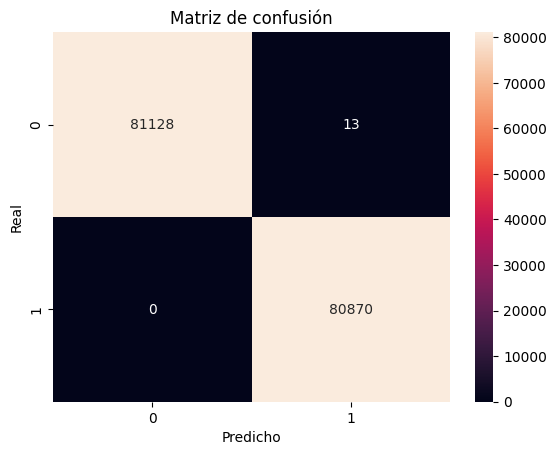

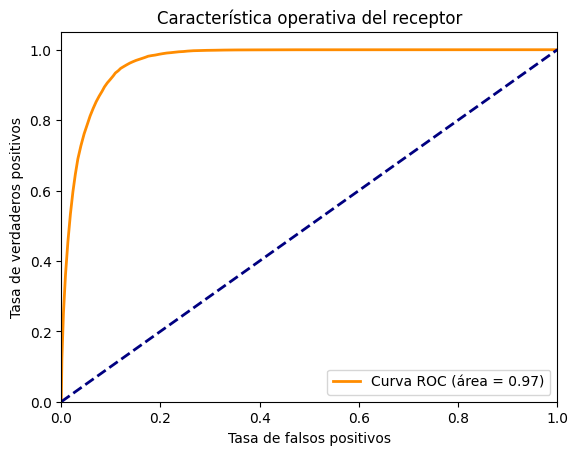

In [ ]:
# Hacer predicciones
y_pred_train = rf.predict(X_train_pca)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train_res, y_pred_train)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Calcular las probabilidades de las clases
y_pred_proba = rf.predict_proba(X_test_pca)[:, 1]

# Calcular la tasa de verdaderos positivos y la tasa de falsos positivos
fpr, tpr, _ = roc_curve(y_test_res, y_pred_proba)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)

# Trazar la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Característica operativa del receptor')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Seleccionar las características relevantes y convertir los datos a enteros
X_test = df_test_tata[['ema5', 'ema20', 'volume', 'CCI15', 'CCI10']]
y_test = df_test_tata['buy_signal']

# Aplicar la transformación PCA a los datos de prueba
X_test_pca = pca.transform(X_res)

# Hacer predicciones con el modelo
y_pred_test = rf.predict(X_test_pca)

# Calcular métricas
accuracy = accuracy_score(y_res, y_pred_test)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_res, y_pred_test)
print(f'Precision: {precision}')

recall = recall_score(y_res, y_pred_test)
print(f'Recall: {recall}')

f1 = f1_score(y_res, y_pred_test)
print(f'F1 Score:  {f1}')

Accuracy: 0.8164401959235266
Precision: 0.8191124920331422
Recall: 0.81225312055617
F1 Score:  0.8156683855612852


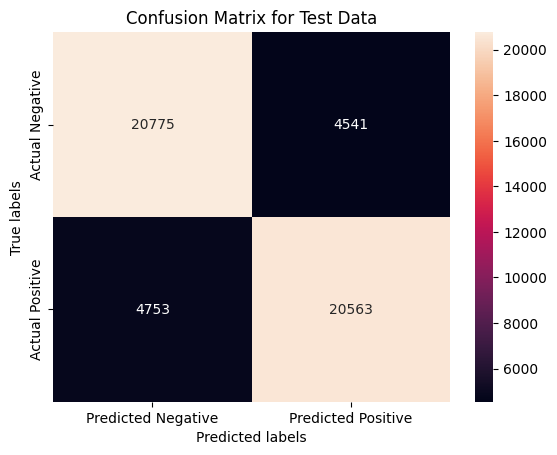

In [ ]:
# Hacer predicciones en los datos de prueba
y_pred_test = rf.predict(X_test_pca)

# Calcular la matriz de confusión
cm_test = confusion_matrix(y_res, y_pred_test)

# Crear un DataFrame a partir de la matriz de confusión para facilitar la visualización
cm_test_df = pd.DataFrame(cm_test, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Crear una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Crear un mapa de calor a partir de la matriz de confusión
sns.heatmap(cm_test_df, annot=True, fmt='g', ax=ax)

# Añadir títulos y etiquetas
ax.set_title('Confusion Matrix for Test Data')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Mostrar la figura
plt.show()

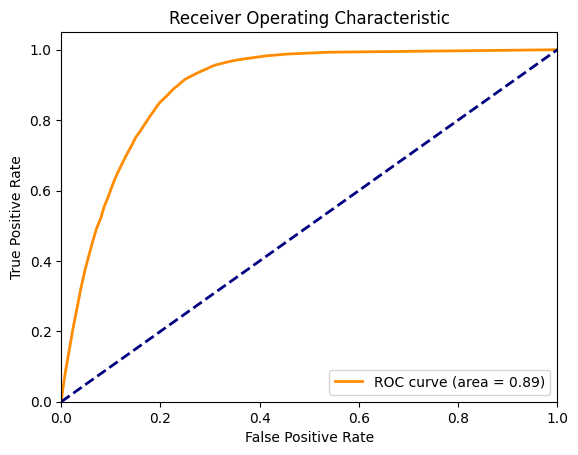

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular las probabilidades de las clases
y_pred_proba = rf.predict_proba(X_test_pca)[::,1]

# Calcular la tasa de verdaderos positivos y la tasa de falsos positivos
fpr, tpr, _ = roc_curve(y_res, y_pred_proba)

# Calcular el área bajo la curva ROC
roc_auc = auc(fpr, tpr)

# Trazar la curva ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

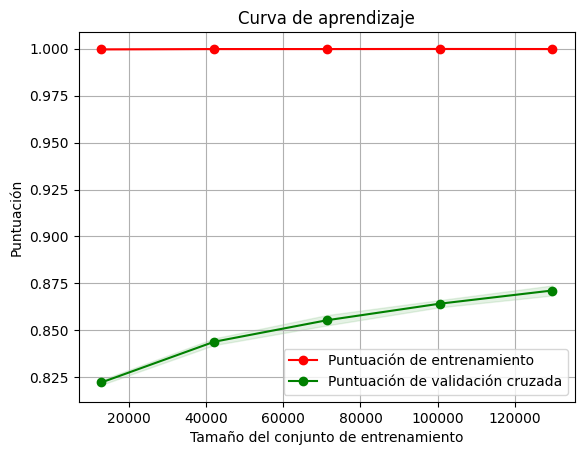

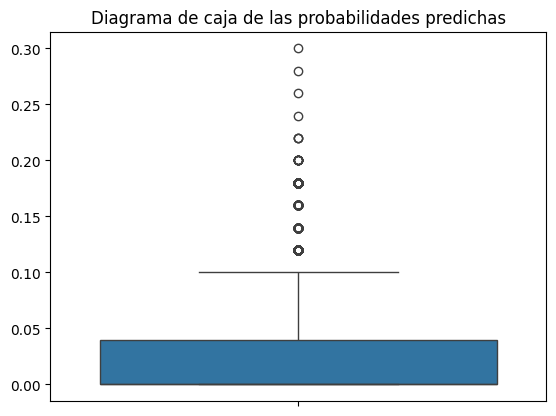

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(rf, X_train_res, y_train_res, cv=5)

# Calcular las medias y los errores estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Trazar la curva de aprendizaje
plt.figure()
plt.title("Curva de aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Puntuación")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntuación de entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntuación de validación cruzada")
plt.legend(loc="best")
plt.show()

# Calcular las probabilidades de las clases
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Crear un diagrama de caja
plt.figure()
sns.boxplot(y=y_pred_proba)
plt.title("Diagrama de caja de las probabilidades predichas")
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=3)
fit = rfe.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
Feature Ranking: [29 24  4 27  1 28 41 44 49 36 39 43 40 14 48 19 45 34 38 32 62 25 31 37
 10  7 15 47  2  1  1 60 50 58 63 55 46 33 23 52 57 51 61  3  8 16  6  5
  9 17 12 18 11 53 26 30 20 54 59 56 21 35 42 22 13]


In [ ]:
selected_features = X.columns[fit.support_]
print("Selected features: ", selected_features)

Selected features:  Index(['volume', 'CCI10', 'CCI15'], dtype='object')
